In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Import & Split Dataset

In [5]:
# Import MINST data
mnist = tf.keras.datasets.mnist
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train.shape, x_train.dtype

((60000, 28, 28), dtype('float32'))

In [6]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])   
x_image_test = tf.reshape(x_test, [-1,28,28,1]) 

x_image_test.shape, x_image_test.dtype

(TensorShape([10000, 28, 28, 1]), tf.float32)

In [52]:
flatten_layer = tf.keras.layers.Flatten()
x_train = flatten_layer(x_train)

x_train.shape

TensorShape([60000, 784])

### Building Autoencoder Model

In [53]:
# Model Parameter
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10
global_step = tf.Variable(0)
total_batch = int(len(x_train) / batch_size)

# Network Parameters
n_hidden_1 = 256 # 1st layer num features
n_hidden_2 = 128 # 2nd layer num features
encoding_layer = 32 # final encoding bottleneck features
n_input = 784 # MNIST data input (img shape: 28*28)
dropout_prob = 0.2

In [54]:
# Building the Autoencoder
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.encoding_layer = encoding_layer
        self.n_input = n_input
        self.dropout_prob = dropout_prob

        self.flatten_layer = tf.keras.layers.Flatten()
        self.enocoding_1 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.encoding_2 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.encoding_final = tf.keras.layers.Dense(self.encoding_layer, activation=tf.nn.relu)
        self.decoding_1 = tf.keras.layers.Dense(self.n_hidden_2, activation=tf.nn.sigmoid)
        self.decoding_2 = tf.keras.layers.Dense(self.n_hidden_1, activation=tf.nn.sigmoid)
        self.decoding_final = tf.keras.layers.Dense(self.n_input)


    # Building the encoder
    def encoder(self, x):
        # x = self.flatten_layer(x)
        layer_1 = self.enocoding_1(x)
        layer_2 = self.encoding_2(layer_1)
        code = self.encoding_final(layer_2)
        return code
        

    # Building the decoder
    def decoder(self, x):
        layer_1 = self.decoding_1(x)
        layer_2 = self.decoding_2(layer_1)
        decode = self.decoding_final(layer_2)
        return decode

        
    def call(self, x):
        encoder_op  = self.encoder(x)
        # Reconstructed Images
        y_pred = self.decoder(encoder_op)
        return y_pred

In [55]:
# Cost function and gradient
def cost(y_true, y_pred):
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    cost = tf.reduce_mean(loss)
    return cost

def grad(model, inputs, targets):
    # print('shape of inputs : ',inputs.shape)
    # targets = flatten_layer(targets)
    with tf.GradientTape() as tape:    
        reconstruction = model(inputs)
        loss_value = cost(targets, reconstruction)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), reconstruction

In [56]:
# Model training
model = AutoEncoder()
optimizer = tf.keras.optimizers.RMSprop(learning_rate)

for epoch in range(training_epochs):
    for i in range(total_batch):
        x_inp = x_train[i : i + batch_size]
        loss_value, grads, reconstruction = grad(model, x_inp, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Testing The Autoencoder

In [57]:
# Applying encode and decode over test set
encode_decode = model(flatten_layer(x_image_test))
encode_decode.shape

TensorShape([10000, 784])

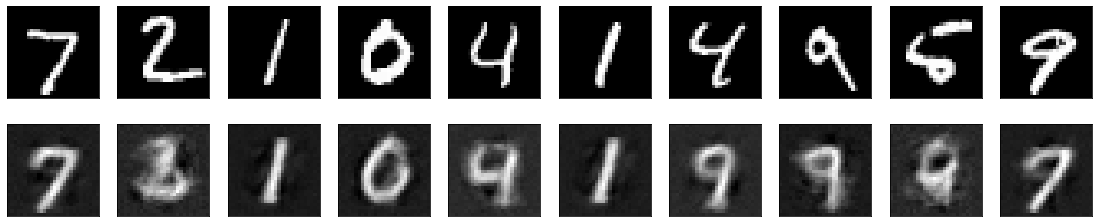

In [59]:
# Compare original images with their reconstructions
f, a = plt.subplots(2, 10, figsize = (20,4), dpi = 70)
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(x_image_test[i], (28,28)))
    a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))

    a[0][i].get_xaxis().set_visible(False)
    a[0][i].get_yaxis().set_visible(False)
    plt.gray()

    a[1][i].get_xaxis().set_visible(False)
    a[1][i].get_yaxis().set_visible(False)
    plt.gray()

plt.show()